### Tutorial: TOMTOM

TOMTOM is an algorithm for determining the similarity between two PWMs. It is composed of two steps. In the first step, each possible alignment between the two PWMs is scored according to the user-defined score function. In principle, this score function can be anything. In practice, using a score function that is additive over the position in the alignment makes TOMTOM much faster. Potentially more importantly, the implementation here only supports Euclidean distance, which has been shown to work very well. In the second step, this score is converted to a p-value that that accounts for motif length and information contents to be comparable across motifs and PWMs. Essentially, one would expect an additive score to be higher as the alignment gets longer and so scores alone cannot be compared across motifs or even, really, across different lengths for the same motif. Consequently, TOMTOM is not a score function itself, but rather an algorithm for converting scores (from any additive score function) into p-values. 

TOMTOM and FIMO are similar in the sense that both involve scanning a PWM against another entity and both result in a score and also a p-value. However, there are key differences between the two that arise from assumptions about <i>overhang effects</i>  and <i>composition</i>. First, because FIMO is meant to scan a PWM against one or more very long sequences, edge effects are largely ignored as being unlikely or unimportant. In contrast, TOMTOM involves scanning a PWM against a database of PWMs that are thought to be of similar length, meaning that there will almost always be overhangs on either side. Scoring these overhangs properly is so important that a [follow-up paper](https://pubmed.ncbi.nlm.nih.gov/21543443/) came out addressing key issues in the [original TOMTOM algorithm](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2007-8-2-r24). Second, FIMO assumes the entity being scanned is one-hot encoded and the background probability of each character is the same at each position in the PWM. Together, these allow a background distribution to be calculated exactly without even needing to see the entities being scanned by the PWM. In contrast, TOMTOM does not make any assumptions about the composition of the entity being scanned and calculates a background distribution empirically *given* a set of PWMs to be scanned against.

Put more simply: <i>use FIMO when you are scanning a PWM against one or more one-hot encoded sequences, and use TOMTOM when you are scanning a query PWM against a database of one or more target PWMs.</i>

An important note, and motivation for this work, is that the PWMs being scanned do not have to be probabilities like those you might download from JASPAR or some other motif database. In theory, neither the query or the target PWMs have to be one-hot encoded. This means that if you have a collection of short one-hot encoded sequences, e.g. those identified by a seqlet caller, you can annotate them with a motif database quickly using TOMTOM. Alternatively, the PWMs can encode any sort of continuous value such as feature attribution scores from a machine learning model. 

#### Using TOMTOM

TOMTOM is implemented as a numba-accelerated function in `memelite.tomtom`. It can take in PWMs as `numpy.ndarray` or as `torch.Tensor` objects. Importantly, `memelite` does not require PyTorch to install but can still handle tensors being passed in by internally converting them.

Conceptually, the TOMTOM algorithm compares a single query PWM against a database of one or more target PWMs. Accordingly, the required inputs to our `tomtom` function are a list of query PWMs and a list of target PWMs, where each query PWM is run independently. Each PWM must be of shape `(len_alphabet, len_seq)`. Let's see this function in action by comparing a one-hot encoded sequence against the 2,348 motifs in JASPAR.

In [1]:
import numpy

from memelite import tomtom
from memelite.io import read_meme   # The same as tangermeme but returns numpy arrays

from tangermeme.utils import one_hot_encode


q = [one_hot_encode("ACGTGT").double().numpy()]

targets = read_meme("../../../common/JASPAR2024_CORE_non-redundant_pfms_meme.txt")
target_names = numpy.array([name for name in targets.keys()])
target_pwms = [pwm for pwm in targets.values()]

p, scores, offsets, overlaps, strands = tomtom(q, target_pwms)
p.shape

(1, 2348)

`tomtom` will return several properties of the best alignment between each of the provided queries and each of the targets with each of these being a matrix of shape `(n_queries, n_targets)`. Because there was only a single query, the first dimension of the p-value matrix is 1. The other properties that are returned are the integerized score that is converted into a p-value, the offset of the best alignment where 0 means that the first character of the query is the first character of the alignment (negative mean that the first characters in the query are not part of the alignment and positive values mean that the first characters of the target are not part of the alignment), the overlap length of the alignment, and which strand the target sequence was on in the best alignment.

Given this information, one can then easily find the motifs that match according to a p-value threshold.

In [2]:
target_names[p[0] < 0.0001]

array(['MA1033.1 OJ1058_F05.8', 'MA1332.2 BEH2', 'MA1333.2 BEH3',
       'MA2014.2 BAM8', 'MA2401.1 Os05g0437700',
       'MA2105.1 GLYMA-13G317000', 'MA0310.2 HAC1'], dtype='<U35')

To check that these are good matches, we should visualize them.

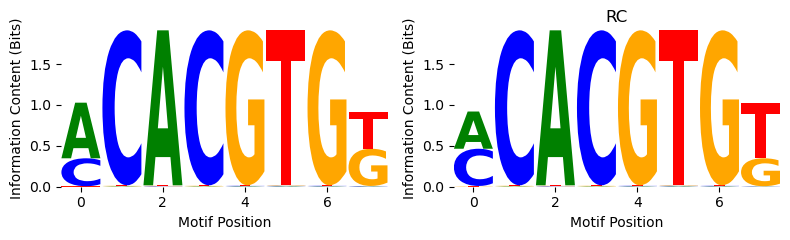

In [3]:
from tangermeme.plot import plot_pwm

plot_pwm(targets['MA1033.1 OJ1058_F05.8'])

Since our sequence was "ACGTGT", looks like there is a pretty strong match! Just to check to make sure the algorithm did the expected thing... what was the offset on the alignment returned by TOMTOM and what was the length of the alignment?

In [4]:
offsets[0, p[0] < 0.0001][0], overlaps[0, p[0] < 0.0001][0]

(2.0, 6.0)

This makes sense. Because the offset is a positive value this means that characters in the target were excluded from the alignment. Here, specifically it means the first two characters were excluded from the alignment. The next six characters are then aligned. Looks like TOMTOM is, indeed, doing what you might expect.

Finally, we can take a look at the score. You might expect that the score would be a float because the distance measure being used is Euclidean distance but, for computational reasons internally, these distances are integerized. Accordingly, the scores will be large positive integers.

In [5]:
scores

array([[480., 397., 534., ..., 370., 392., 473.]])

Next, let's take a look at the connection between this integerized score and the p-value.

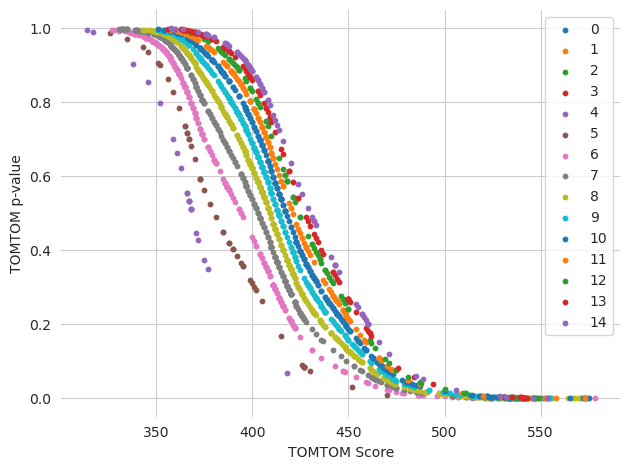

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

l = numpy.array([p.shape[1] for p in target_pwms])

for i in range(15):
    plt.scatter(scores[0][l == i], p[0][l== i], s=10, label=i)

plt.xlabel("TOMTOM Score")
plt.ylabel("TOMTOM p-value")
plt.legend()

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

You might have expected that there would be a monotonic relationship between score and p-value. This is only true after conditioning on the length of the target sequence (as you can see by the colors) because there is a separate background distribution constructed for each target length.

Next, we can compare these p-values against the ones produced by the command-line tool from the MEME suite to make sure that they are correct. First, we will write out the query motif (which is just the one-hot encoded sequence from before), run the command-line tool, and then read the results back into Python.

In [7]:
import os
import pandas
from memelite.io import write_meme

write_meme(".tomtom.test", q)

os.system("tomtom .tomtom.test ../../../common/JASPAR2024_CORE_non-redundant_pfms_meme.txt -motif-pseudo 0 -thresh 1 -text > .tomtom.results")

df = pandas.read_csv(".tomtom.results", sep="\t", comment='#')
df.head()

Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 4696 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.938049
#   Estimated pi_0=0.938049


,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,0,MA2105.1,0,0.000011,0.024870,0.041142,6,ACGTGT,ACGTGT,-
1,0,MA0310.2,0,0.000055,0.130306,0.041142,6,ACGTGT,ACGTGTC,-
2,0,MA2014.2,2,0.000077,0.181374,0.041142,6,ACGTGT,GCACGTGTG,-
3,0,MA1333.2,3,0.000084,0.198021,0.041142,6,ACGTGT,CGCACGTGTG,+
4,0,MA1033.1,2,0.000093,0.217986,0.041142,6,ACGTGT,ACACGTGT,-


Note that the lines here are ordered by the p-value but the entries in `p` from earlier are in the original order of target motifs. We could either try to map the target IDs back to their original positions or simply sort both sets of p-values and assume that the only way they could line up perfectly is if they were both the same value. This seems sufficient to me.

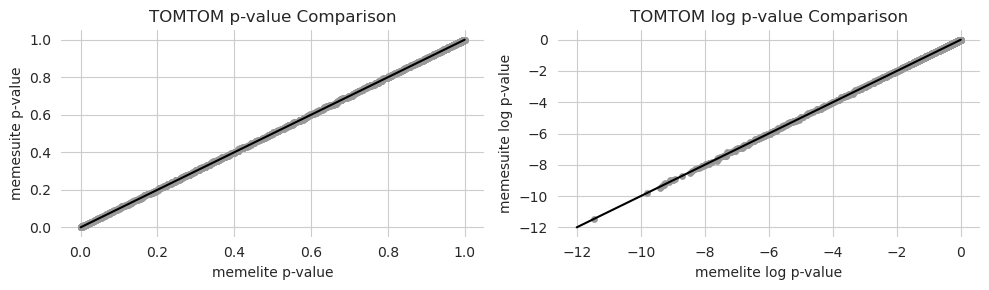

In [8]:
plt.figure(figsize=(10, 3))
plt.subplot(121)

plt.title("TOMTOM p-value Comparison")
plt.scatter(sorted(p[0]), df['p-value'], s=15, c='0.6')
plt.plot([0, 1], [0, 1], c='k')

plt.xlabel("memelite p-value")
plt.ylabel("memesuite p-value")
seaborn.despine(bottom=True, left=True)
           
           
plt.subplot(122)

plt.title("TOMTOM log p-value Comparison")
plt.scatter(numpy.log(sorted(p[0])), numpy.log(df['p-value']), s=15, c='0.6')
plt.plot([-12, 0], [-12, 0], c='k')

plt.xlabel("memelite log p-value")
plt.ylabel("memesuite log p-value")

seaborn.despine(bottom=True, left=True)
           
plt.tight_layout()
plt.show()

Looks like they line up pretty closely!

#### Timings

Now that we have seen that the command-line tool and the Python function yield basically the same p-values, let's take a look at how fast they can do so. When one uses the MEME suite webserver to run TOMTOM, they may notice that it takes several seconds to run a single query against a target database. Although the command-line tool is faster (as jobs do not need to be submitted, queued, and then wait for available resources), one may still wonder if it is possible to do large-scale comparisons with it. Because calling out to a command-line tool from Python can take some time, let's make sure we are doing enough work to marginalize out that factor here in this notebook. As a simple large-scale task, we can compare the entire JASPAR2024 database against itself.

In [9]:
%timeit tomtom(target_pwms, target_pwms)

9.53 s ± 416 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# This step may take some time.

%timeit -n 1 -r 1 os.system("tomtom ../../../common/JASPAR2024_CORE_non-redundant_pfms_meme.txt ../../../common/JASPAR2024_CORE_non-redundant_pfms_meme.txt -motif-pseudo 0 -thresh 1 -text -verbosity 1 > .tomtom.results")

29min 47s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Looks like the Python function is significantly faster than the command-line tool (though you may notice that it takes a few seconds for numba to load initially due to some issues there). There are several reasons why the Python function is faster but there are two main sources of speedup. The first is that the command-line tool calculates the background distribution from scratch <i>for each query-target pair</i> even though this distribution depends only on the length of the target sequence. memelite simply calculates these distributions once at the beginning of the run and re-uses them. The second is that memelite uses a series of approximations to speed up the internal steps significantly while still returning results that are essentially the same.

As a result of these approximations, the runtime scaling of memelite TOMTOM is actually sub-linear with respect to the number of targets. To demonstrate that, let's re-run memelite's TOMTOM but with multiple copies of JASPAR in the target set.

In [11]:
%timeit tomtom(target_pwms, target_pwms*10)

12.5 s ± 1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like the calculation only took slightly longer than using the original number of targets! This is because one of the approximations that is done involves collapsing columns across the targets that are redundant with each other. Basically, instead of repeating a similarity measure between a column in the query sequence and columns in the targets that are the same thing over and over... this is only done once and the result gets cached. Because we are literally copying the sequences 10 times in a row, this redundancy-reducing mechanism is on full display and so it is unsurprising that the time does not increase by that much. This is an important point because as target databases get larger, *they get more redundant*. So, while we may not see speed improvements as large as we saw here, we will still see time only increase *sublinearly* with the number of targets once the number of targets gets large.

That being said, this is an extreme case of redundancy. The expected speedup is very dependent on the composition of the data and the number of bins being used to hash the columns. To check the timings more comprehensively, we can compare time against a steadily increasing target database size.

In [12]:
import time
from tqdm import tqdm

timings = []

n_motifs = list(range(1, len(target_pwms), 25))
for n_motif in tqdm(n_motifs):
    tic = time.time()
    for _ in range(50):
        tomtom(target_pwms[:1], target_pwms[:n_motif])
    toc = time.time() - tic
    
    timings.append(toc / 50)

100%|██████████| 94/94 [01:27<00:00,  1.08it/s]


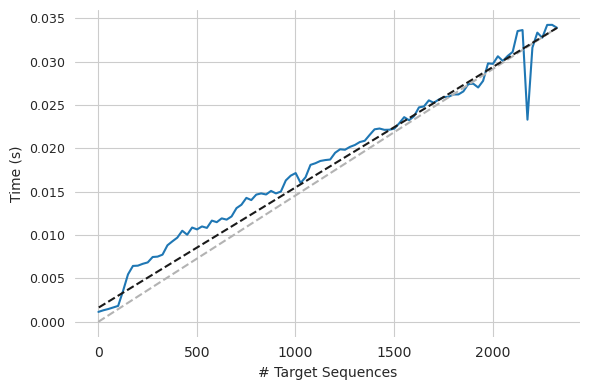

In [13]:
plt.figure(figsize=(6, 4))

plt.plot(n_motifs, timings)
plt.plot([0, n_motifs[-1]], [0, timings[-1]], c='0.7', linestyle='--')
plt.plot([3, n_motifs[-1]], [timings[3], timings[-1]], c='0.1', linestyle='--')

plt.xlabel("# Target Sequences")
plt.ylabel("Time (s)")
plt.yticks(fontsize=9)

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

It looks like the main trend for a database with the composition of JASPAR is a roughly linear increase in time as the size of the database increases. However, even though the trend is linear the coefficient is rather small. It only takes ~7x as long to run a query against all 2,348 targets as it does to run the query against a single target. Since each query is independent, `tomtom` scales roughly linearly in both directions (though it is parallelized across queries) until the point where the target database becomes extremely redundant, at which point it begins scaling sub-linearly with the size of the database.

#### Nearest Neighbors

In some applications, you may not need to have the entire `query x target` similarity matrix returned. Instead, you may only want some number of nearest neighbors. This is particularly relevant when scaling to either massive number of queries or targets because the entire matrix may not fit in memory! In these cases, you can specify that you only want to keep the closest `n_nearest` neighbors (according to p-value) and get a `query x n_neighbors` matrix of similarities instead. Note that this does not yet speed up the calculation of these nearest neighbors, but just reduces the amount of memory needed. 

Let's see an example where all we want is the nearest 100 targets for each query.

In [14]:
p, _, _, _, _, idxs = tomtom(target_pwms, target_pwms, n_nearest=100)
p.shape

(2348, 100)

Instead of returning a `(2348, 2348)` matrix like we would get before, we get a `(2348, 100)` one with only the nearest neighbors. An important practical note is that this subseting to only the nearest neighbors happens as the last step for each query and not just at the very end of the entire process. This means that the amount of memory needed to run TOMTOM when only keeping the nearest neighbors scales linearly with the number of queries. 

An important consideration is that the nearest neighbors for each query will be different. To keep track of *which* targets are being returned for each query, an additional matrix is returned that contains the target indexes for each of the nearest neighbors. In this matrix, element `(i, j)` means the target index of the j-th nearest neighbor for the i-th query.

In [15]:
idxs[0, :10]

array([  0., 131., 142., 121.,  41., 155., 229.,  93., 160., 638.])

As you might expect, when calculating the similarity between a set of motifs and itself, the motif itself will be the highest similarity match (hence the 0 as the first index). The best target match that is not a self-match is at position 131.

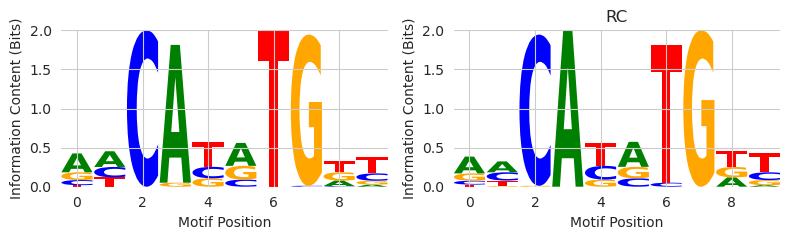

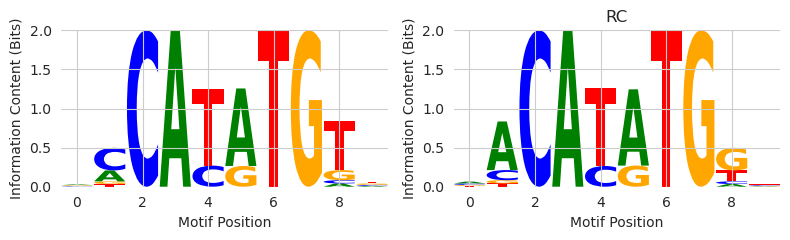

In [16]:
plot_pwm(target_pwms[131])
plot_pwm(target_pwms[0])

Looks pretty similar to me!

#### Approximation Parameters

The implementation in `memelite` uses a few appproximation tricks to speed up the TOMTOM algorithm without a significant loss in precision. In general, these tricks involve bins, where the more bins the better the approximation but the more time they take. The default values have been tried in a few situations involving PWMs and seem to work reasonably well, but if you have a non-standard setting you may need to change them. They are:

`n_score_bins`: This is the parameter `t` from the TOMTOM paper. The 100 number is hardcoded into the TOMTOM command-line algorithm from the MEME suite, but can be changed conceptually. However, in addition to setting a higher value taking more time, you will need more data to support each of the bins. Only set to a higher value when you have enough target columns to support them, otherwise you may get weirdly bad results.

`n_median_bins`: When calculating medians, `memelite` avoids a `O(n log n)` sort step and instead implements a linear-time approximation by binning the range, counting the instances in each bin, and checking what bin corresponds to a cumulative half of all examples. The average value of the examples in the median bin (rather than the middle of the bin) is returned, for higher accuracy.

`n_target_bins`: Each value in the target column (each of the four nucleotides in standard cases) are binned into this number of bins from the minimum observed value to the maximum observed value. Target columns that are identical across each value are merged to speed up the inner loop.